In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("framingham.csv")

# Missing values are removed to simplify preprocessing.
# Although this may reduce the dataset size, it ensures that
# the model receives clean and valid numerical inputs.
df = df.dropna()

# Separate features and target
# X contains all independent variables, while y contains the
# binary label indicating heart disease presence.
X = df.drop("TenYearCHD", axis=1).values
y = df["TenYearCHD"].values


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.losses = []   # ⭐ THIS LINE IS CRITICAL

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def loss(self, y, y_pred):
        epsilon = 1e-9
        return -np.mean(
            y * np.log(y_pred + epsilon) +
            (1 - y) * np.log(1 - y_pred + epsilon)
        )

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            current_loss = self.loss(y, y_pred)
            self.losses.append(current_loss)   #  stores loss

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        return np.where(y_pred >= 0.5, 1, 0)



In [12]:
import time

scratch_model = LogisticRegressionScratch(lr=0.01, epochs=2000)

start = time.time()
scratch_model.fit(X_train, y_train)
scratch_time = time.time() - start

y_pred_scratch = scratch_model.predict(X_test)


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

scratch_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_scratch),
    "Precision": precision_score(y_test, y_pred_scratch),
    "Recall": recall_score(y_test, y_pred_scratch),
    "F1": f1_score(y_test, y_pred_scratch),
    "Training Time (s)": scratch_time
}

scratch_metrics


{'Accuracy': 0.8360655737704918,
 'Precision': 0.5833333333333334,
 'Recall': 0.05737704918032787,
 'F1': 0.1044776119402985,
 'Training Time (s)': 0.574138879776001}

In [14]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(max_iter=2000)

start = time.time()
sk_model.fit(X_train, y_train)
sk_time = time.time() - start

y_pred_sk = sk_model.predict(X_test)


In [15]:
sk_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_sk),
    "Precision": precision_score(y_test, y_pred_sk),
    "Recall": recall_score(y_test, y_pred_sk),
    "F1": f1_score(y_test, y_pred_sk),
    "Training Time (s)": sk_time
}

sk_metrics


{'Accuracy': 0.8360655737704918,
 'Precision': 0.5555555555555556,
 'Recall': 0.08196721311475409,
 'F1': 0.14285714285714285,
 'Training Time (s)': 0.01424860954284668}

In [16]:
comparison = pd.DataFrame([scratch_metrics, sk_metrics],
                           index=["From Scratch", "Scikit-learn"])
comparison


,Accuracy,Precision,Recall,F1,Training Time (s)
From Scratch,0.836066,0.583333,0.057377,0.104478,0.574139
Scikit-learn,0.836066,0.555556,0.081967,0.142857,0.014249


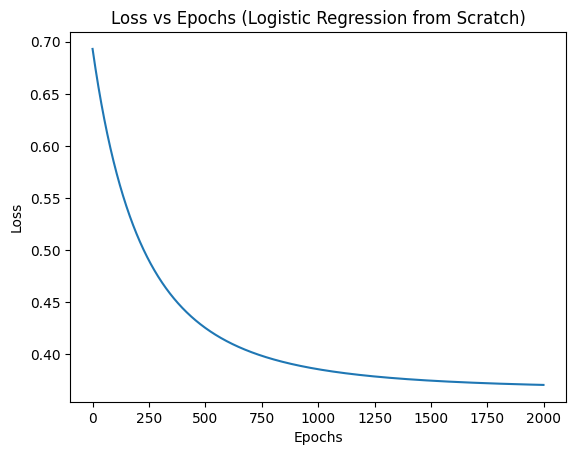

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(scratch_model.losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Logistic Regression from Scratch)")
plt.show()


In [ ]:
# Plot loss versus epochs to observe the convergence behavior
# of the gradient descent algorithm. A decreasing loss curve
# indicates that the model is learning effectively.